In [1]:
from PIL import Image
from pathlib import Path
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize

In [2]:
def is_image_file(p: Path) -> bool:
    return any(str(p).endswith(extension) for extension in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'])

In [3]:
def check_image_size(image: Image) -> tuple:
    width, height = image.size
    return (width, height)

In [4]:
class TrainDatasetLoader(Dataset):
    def __init__(self, dataset_dir: Path, crop_size: int, factor: int) -> None:
        super().__init__()
        self.crop_size = crop_size

        # Files
        self.image_files = [p for p in dataset_dir.iterdir() if p.is_file() and is_image_file(p.absolute())]

        # Transform
        self.hr_transform = Compose([
            RandomCrop(self.crop_size),
        ])

        self.lr_transform = Compose([
            Resize(self.crop_size // factor, interpolation=Image.BICUBIC),
            ToTensor()
        ])
        
        self.to_tensor = ToTensor()


    def __getitem__(self, index: int) -> tuple:
        sample = Image.open(self.image_files[index])
        hr_image = self.hr_transform(sample)
        lr_image = self.lr_transform(hr_image)
        hr_image = self.to_tensor(hr_image)
        
        return lr_image, hr_image

    
    def __len__(self) -> int:
        return len(self.image_files)
    

In [5]:
a = TrainDatasetLoader(Path('./dataset'), 88, 2)

In [6]:
len(a)

74221

In [7]:
l, h = a[450]

In [8]:
l.shape

torch.Size([3, 44, 44])

In [9]:
tf_img = ToPILImage()

In [10]:
cv_image = tf_img(l)

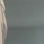

In [11]:
display(cv_image)

In [12]:
cv_image2 = tf_img(h)

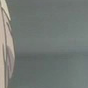

In [13]:
cv_image2

In [14]:
h.shape

torch.Size([3, 88, 88])

In [15]:
class ValidationDatasetLoader(Dataset):
    def __init__(self, dataset_dir: Path, factor: int) -> None:
        super().__init__()
        self.factor = factor
        self.image_files = [p for p in dataset_dir.iterdir() if p.is_file() and is_image_file(p.absolute())]
        self.to_tensor = ToTensor()

        
    def __getitem__(self, index: int) -> tuple:
        # Returns a tuple of tensor (images)
        # (Low resolution, Low resolution in original size, High resolution)
        sample = Image.open(self.image_files[index])
        width, height = sample.size
        crop_size = min(width, height)
        crop_size = crop_size - crop_size % self.factor
        
        hr_transform = CenterCrop(crop_size)
        lr_transform = Resize(crop_size// self.factor, interpolation=Image.BICUBIC)
        restore_transform = Resize(crop_size, interpolation=Image.BICUBIC)

        hr_image = hr_transform(sample)
        lr_image = lr_transform(hr_image)
        hr_restore_img = restore_transform(lr_image)
        
        return self.to_tensor(lr_image), self.to_tensor(hr_restore_img), self.to_tensor(hr_image)    
    
    
    def __len__(self) -> int:
        return len(self.image_files)
        

In [16]:
b = ValidationDatasetLoader(Path('./dataset'), 2)

In [17]:
lti, htri, hti = b[2]

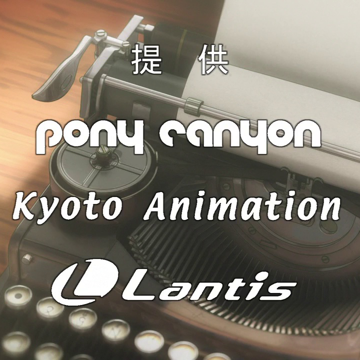

In [18]:
tf_img(lti)

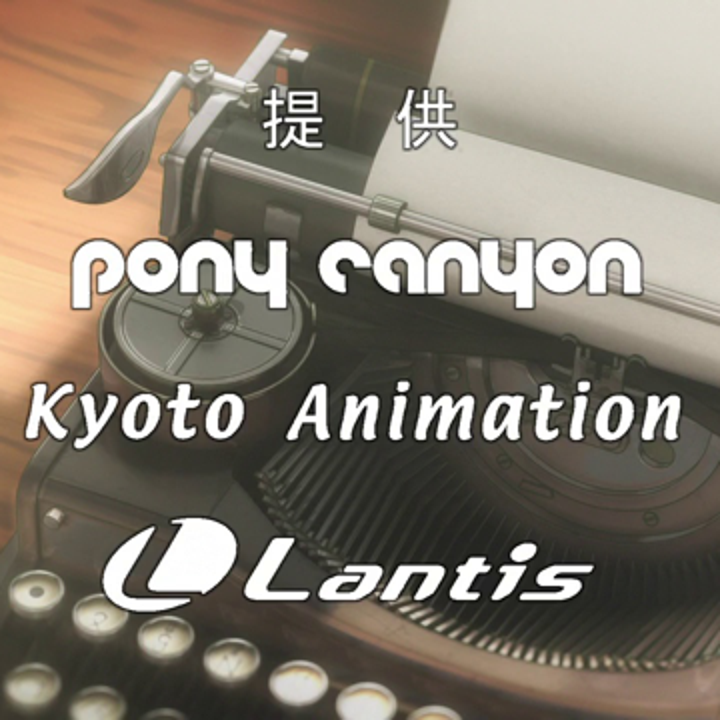

In [19]:
tf_img(htri)

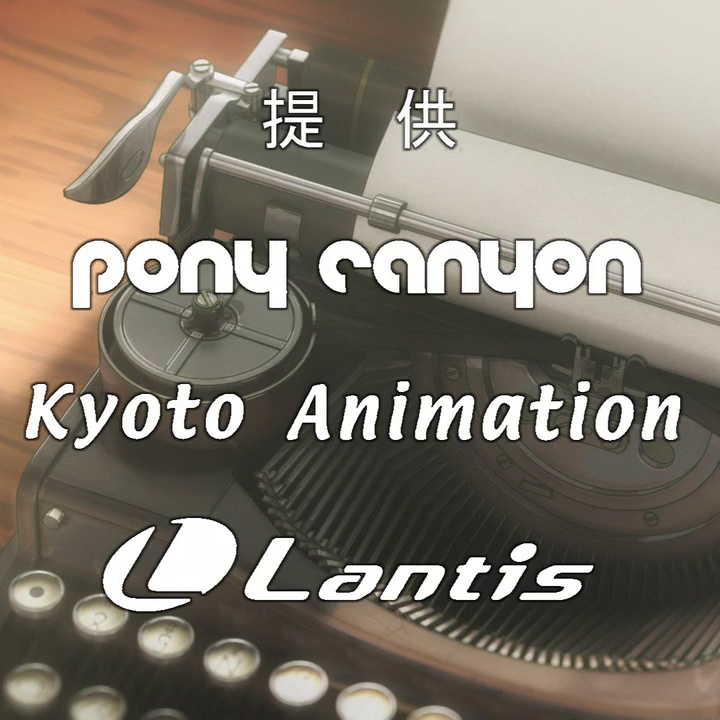

In [20]:
tf_img(hti)

In [21]:
class TestDatasetLoader(Dataset):
    def __init__(self, dataset_dir: Path, factor: int, prefix: str) -> None:
        super().__init__()
        self.lr_file_path = dataset_dir / f'{prefix}_{factor}x' / '/data'
        self.hr_file_path = dataset_dir / f'{prefix}_{factor}x' / '/target'
        
        self.to_tensor = ToTensor()
        self.factor = factor
        
        self.lr_files = [p for p in self.lr_file_path.iterdir() if p.is_file() and is_image_file(p.absolute())]
        self.hr_files = [p for p in self.hr_file_path.iterdir() if p.is_file() and is_image_file(p.absolute())]
        
        
    def __getitem__(self, index: int) -> tuple:
        image_name = self.lr_files[index].name
        lr_image = Image.open(self.lr_files[index])
        hr_image = Image.open(self.hr_files[index])
        w, h = lr_image.size
        hr_transform = Resize((self.factor * h, self.factor * w), interpolation=Image.BICUBIC)
        hr_restored_img = hr_transform(lr_image)
        

        
        return image_name, self.to_tensor(lr_image), self.to_tensor(hr_restored_img), self.to_tensor(hr_image)
        
        
    def __len__(self) -> int:
        return len(self.lr_files)
        